In [1]:
%matplotlib inline
import sys
sys.path.insert(0, 'datasets/medical/siim-acr-pneumothorax-segmentation/input')

import pandas as pd
import sys
import csv

from fastai import *
from fastai.vision import *
from model_utils import *
from mask_functions import rle2mask
from fastai.callbacks.hooks import num_features_model

1.0.54


In [2]:
TRAIN_PATH = "/media/disk6tb/datasets/medical/siim-acr-pneumothorax-segmentation/resized/128/train/"
LABEL_PATH = "/home/sairahul/myfiles/durga/dataset/overlap_masks_new.csv"
RAW_MASKS = "/home/sairahul/myfiles/durga/dataset/train-rle.csv"

df = pd.read_csv(LABEL_PATH)
df.head(10)

,image1,image2,label
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,1
1,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,1.2.276.0.7230010.3.1.4.8323329.11364.15178752...,1
2,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,1.2.276.0.7230010.3.1.4.8323329.4541.151787518...,1
3,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,1.2.276.0.7230010.3.1.4.8323329.31759.15178751...,1
4,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,1.2.276.0.7230010.3.1.4.8323329.11512.15178752...,1
5,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,0
6,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,1.2.276.0.7230010.3.1.4.8323329.3722.151787517...,0
7,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,1.2.276.0.7230010.3.1.4.8323329.10576.15178752...,0
8,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,1.2.276.0.7230010.3.1.4.8323329.11135.15178752...,0
9,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,1.2.276.0.7230010.3.1.4.8323329.5122.151787518...,0


In [3]:
PAIRS = defaultdict(list)
PAIRS_LABEL = {}
for index, row in df.iterrows():
    PAIRS[row['image1']].append([row['image2'], row['label']])
    PAIRS_LABEL[(row['image1'], row['image2'])] = row['label']
    
LABELS = {}
with open(RAW_MASKS, "r") as fp:
    reader = csv.reader(fp)
    header = next(reader)
    for _id, mask in reader:
        mask = mask.strip()
        _id = _id.strip()
        if mask == "-1":
            LABELS[_id] = 0
            continue
        LABELS[_id] = 1    

In [4]:
PAIRS['1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090']

[['1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137', 1],
 ['1.2.276.0.7230010.3.1.4.8323329.11364.1517875232.606684', 1],
 ['1.2.276.0.7230010.3.1.4.8323329.4541.1517875183.370160', 1],
 ['1.2.276.0.7230010.3.1.4.8323329.31759.1517875156.671103', 1],
 ['1.2.276.0.7230010.3.1.4.8323329.11512.1517875233.270680', 1],
 ['1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709', 0],
 ['1.2.276.0.7230010.3.1.4.8323329.3722.1517875179.149102', 0],
 ['1.2.276.0.7230010.3.1.4.8323329.10576.1517875224.381916', 0],
 ['1.2.276.0.7230010.3.1.4.8323329.11135.1517875231.335673', 0],
 ['1.2.276.0.7230010.3.1.4.8323329.5122.1517875186.514632', 0]]

In [5]:
# Refer: Pneumothorax%20data%20repack%20and%20image%20statistics.ipynb . Used 128px image stats
mean, std = torch.tensor(([0.6149, 0.6149, 0.6149], [0.2944, 0.2944, 0.2944]))
class SiamImage(ItemBase):
    def __init__(self, img1, img2): ## These should of Image type
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])

In [6]:
class SiamImageList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self._label_cls=FloatList

    def __len__(self)->int: return len(self.items) or 1 

    def get(self, i):
        fn = self.items[i]
        fn1, fn2 = self.items[i]
        img1 = super().open(fn1)
        img2 = super().open(fn2)
        return SiamImage(img1, img2)

    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])

    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        
    @classmethod
    def from_folder(cls, path):
        items = []
        for file in path.glob("*"):
            _id = file.name.rsplit('.', 1)[0]
            for img, label in PAIRS[_id]:
                related_img = file.parent.joinpath(f"{img}.png")
                assert(related_img.is_file())
                items.append([file, related_img])

        return cls(items)
#siam = SiamImageList.from_folder(path=Path(TRAIN_PATH))    

from fastai.vision import learner

class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet34, lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        #self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        #self.head = learner.create_head(num_features_model(self.body), self.emb_sz, self.lin_ftrs, self.ps,self.bn_final)
        #self.cnn = nn.Sequential(self.body, self.head)
        self.cnn = create_cnn_model(self.arch, emb_sz, cut=None, pretrained=True, lin_ftrs=lin_ftrs, ps=self.ps, bn_final=self.bn_final)

    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

In [7]:
# https://github.com/adambielski/siamese-triplet/blob/master/losses.py
class ContrastiveLoss(nn.Module):
    """Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin=1.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        #pdist = dist*target
        #ndist = dist*(1-target)
        #loss = 0.5 * ((pdist**2) + (F.relu(self.margin-ndist)**2))
        losses = 0.5 * (target.float() * dist +
                (1 + -1 * target).float() * F.relu(self.margin - (dist + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [8]:
def gen_label(imgs):
    img1 = imgs[0].name.rsplit('.', 1)[0]
    img2 = imgs[1].name.rsplit('.', 1)[0]
    return float(PAIRS_LABEL[(img1, img2)])

In [9]:
data = (SiamImageList.from_folder(path=Path(TRAIN_PATH))
                    .split_by_rand_pct()
                    .label_from_func(gen_label, label_cls=FloatList)
                    .databunch(bs=384))

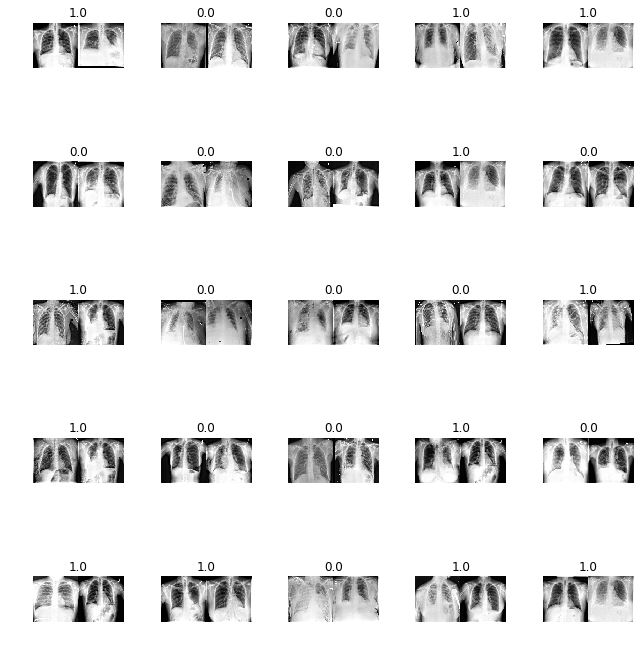

In [10]:
data.show_batch(5)

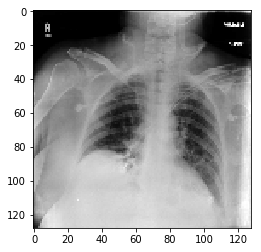

In [11]:
x = next(iter(data.train_dl))
t=x[0][0][0].cpu()
to = mean[...,None,None] + t* std[...,None,None]
import torchvision
ti = torchvision.transforms.ToPILImage(to)
plt.imshow(to.numpy().transpose(1,2,0))

In [12]:
def acc_siamese(preds, targs):
    s = np.zeros(targs.shape)
    p = np.where(preds > 0.5)[0]
    s[p] = 1
    return (s==targs.cpu().numpy()).mean()

In [13]:
def get_learner():
    model = SiameseNet().cuda()
    apply_init(model.cnn[1], nn.init.kaiming_normal_)
    loss_func=ContrastiveLoss().cuda()
    siam_learner = Learner(data, model, loss_func=loss_func, model_dir=Path(os.getcwd()), layer_groups=[model.cnn[0], model.cnn[1]], opt_func=optim.SGD)
    #siam_learner.metrics=[acc_siamese] Note: it doesn't makesense calculating the loss.
    return siam_learner
siam_learner = get_learner()

In [14]:
siam_learner.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


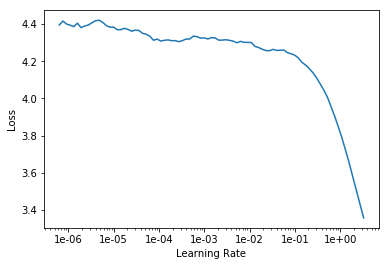

In [15]:
siam_learner.lr_find()
siam_learner.recorder.plot()

In [16]:
#siam_learner.fit_one_cycle(20, slice(1*1e-2), div_factor=30., pct_start=0.9, moms=(0.95, 0.85))
siam_learner.fit_one_cycle(10, 1e-1, div_factor=30., pct_start=0.9, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,time
0,0.537626,0.137640,01:54
1,0.117267,0.129820,01:54
2,0.109226,0.126580,01:54
3,0.107115,0.123278,01:54
4,0.105957,0.121310,01:54
5,0.103866,0.119897,01:54
6,0.101352,0.120410,01:54
7,0.099569,0.119558,01:54
8,0.095799,0.120453,01:54
9,0.089998,0.117215,01:54


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


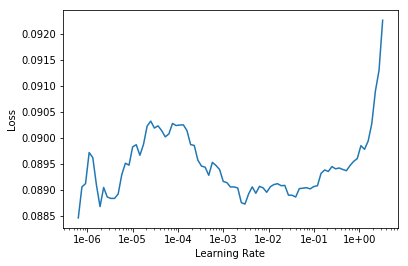

In [17]:
siam_learner.unfreeze()
siam_learner.lr_find()
siam_learner.recorder.plot()

In [18]:
siam_learner.fit_one_cycle(10, 1e-2, div_factor=20., pct_start=0.7, moms=(0.95, 0.85))
#siam_learner.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,time
0,0.087687,0.116813,02:26
1,0.085057,0.118979,02:26
2,0.081712,0.117388,02:26
3,0.077714,0.120183,02:26
4,0.075192,0.115248,02:26
5,0.072366,0.116538,02:26
6,0.068777,0.114441,02:26
7,0.067813,0.114212,02:26
8,0.064706,0.111335,02:26
9,0.062401,0.111067,02:26


In [19]:
def extract_features(model, dirname, batch_size=512):
    dirname = Path(dirname)
    allfiles = [each_file for each_file in dirname.glob("*")]
    image_features = []
    for i in range(0, len(allfiles), batch_size):
        batch_files = allfiles[i:i+batch_size]
        
        img_batch = []
        for img in batch_files:
            img = open_image(img)
            img_batch.append(img.data)
        
        img_batch = torch.stack(img_batch, 0)
        features = model.get_embedding(img_batch.cuda())
        features = features.cpu()
        
        for img, feature in zip(batch_files, features):
            image_features.append(feature.flatten().numpy())
    
    return allfiles, np.stack(image_features, axis=0)

def display_closest(index, query_index, files, image_features):
    get_lbl = lambda fn: LABELS[fn.name.rsplit('.', 1)[0]]

    dists, indexes = index.search(image_features[query_index][None,:], 12)

    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    fn = files[query_index]
    ax = axes[0][0]
    
    show_image(open_image(fn), ax=ax)
    axes[0][0].set_title(get_lbl(fn))
    for ax in axes[0][1:]:
        ax.axis('off')
    for i,ax in enumerate(axes.flat[4:]):
        fn = files[indexes[0][i]]
        show_image(open_image(fn), ax=ax)
        ax.set_title(get_lbl(fn))

In [20]:
siam_learner.model.eval()
for param in siam_learner.model.parameters():
    param.requires_grad = False

In [21]:
new_files, new_image_features = extract_features(siam_learner.model, TRAIN_PATH)

In [22]:
import faiss
nlist = 100  # number of clusters
quantiser = faiss.IndexFlatL2(128)
index = faiss.IndexIVFFlat(quantiser, 128, nlist, faiss.METRIC_L2)

In [23]:
index.train(new_image_features)
index.add(new_image_features)

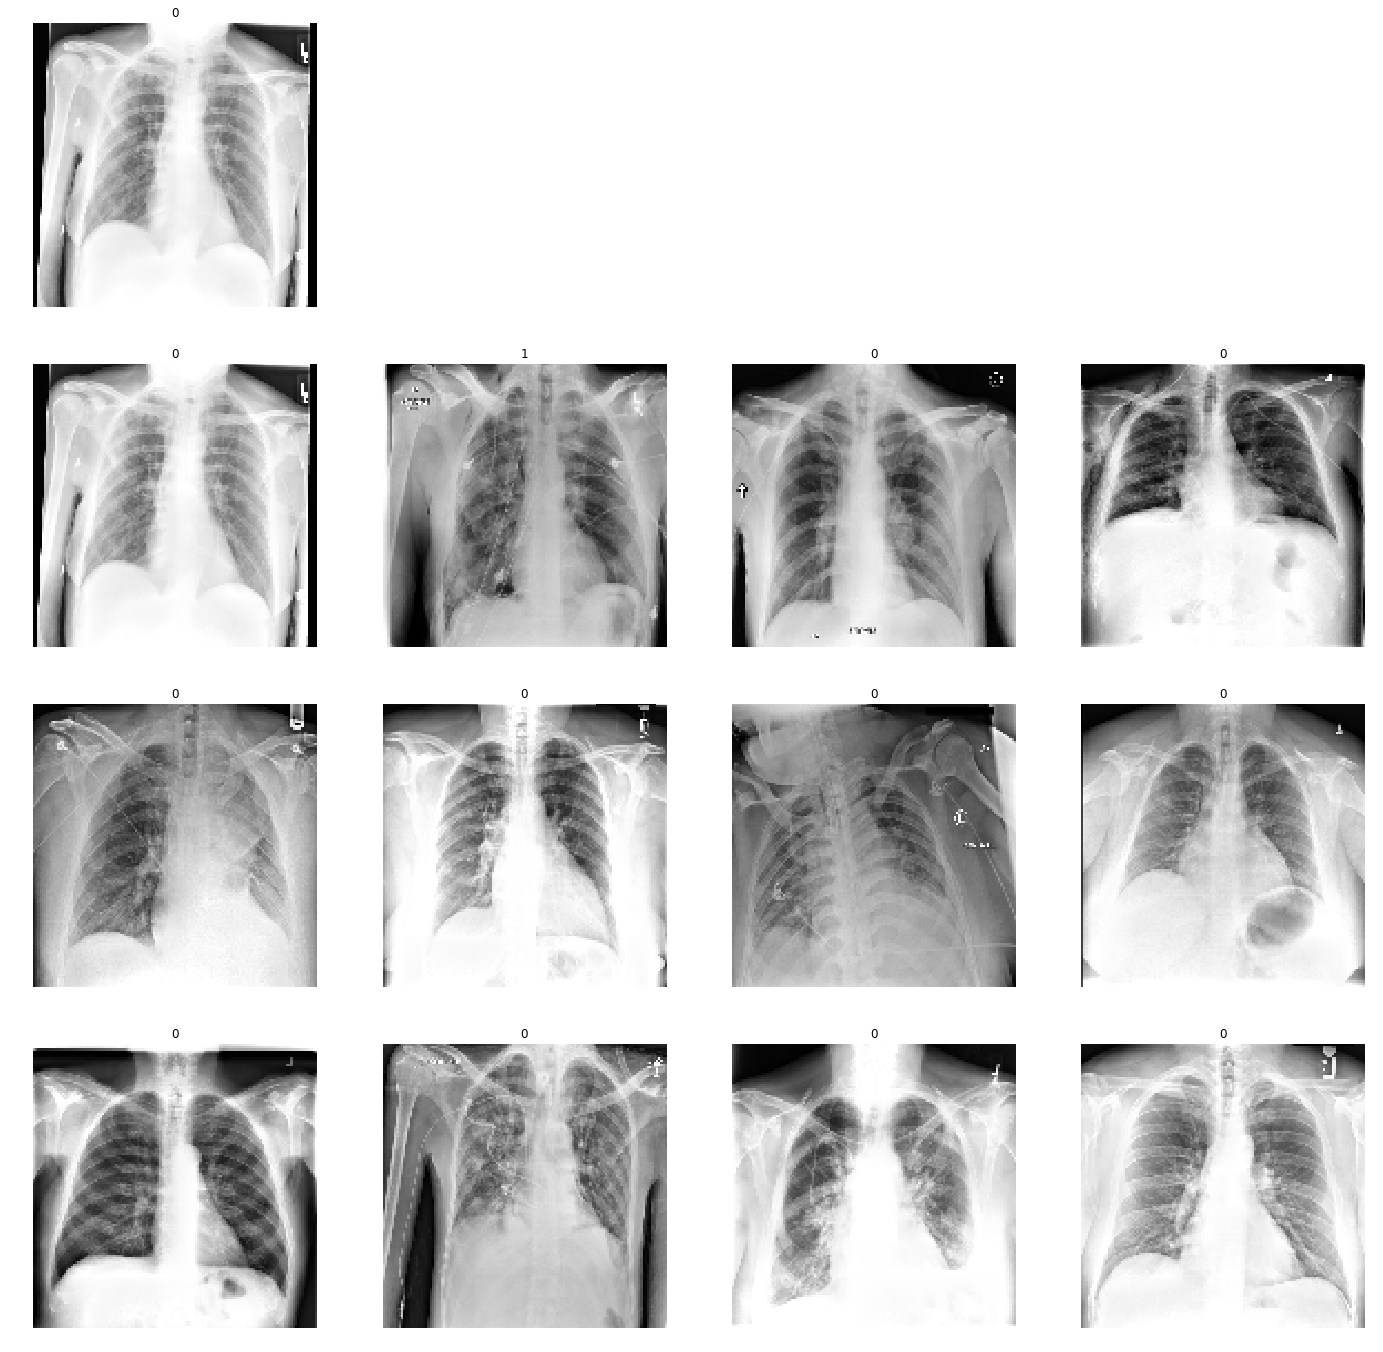

In [44]:
display_closest(index, 32, new_files, new_image_features)

In [45]:
siam_learner.save('siam_leaner_pneumothorax')